In [1]:
#Import tweet database of 33K tweets with username and location information
import pandas as pd
db=pd.read_csv('newtweets_Nepal11Apr-9thMay_complete.txt',encoding='utf-16',sep='\t')

In [2]:
##Read initial tweet database, extract mapping of users to L3,L4 and check much a user stays at the same location

from collections import Counter

userlocarray=[]
for user in set(db.Username):
    userL3=db[db.Username==user].L3 #Get subset of the dataframe for this user and the L3 column
    userL4=db[db.Username==user].L4
    L3counts=Counter(userL3)
    L4counts=Counter(userL4)
    
    L3common=L3counts.most_common(1)[0][0] #access the most common L3 name
    L3num=L3counts.most_common(1)[0][1] #access the most common L3 count
    L4common=L4counts.most_common(1)[0][0]
    L4num=L4counts.most_common(1)[0][1]   
    L3ratio=L3num/len(userL3) #freq of most common item over all items-> should be close to 1
    L4ratio=L4num/len(userL4)
    userlocarray.append([user,L3common,L3ratio,L4common,L4ratio])
    

In [3]:
#Add L1 and L2 information to the existing username-location database

import nltk

#Create a Pandas database out of the existing array of usernames and L3,L4 identified earlier
df_loc = pd.DataFrame(userlocarray,columns=['Username','L3_common','L3_common_ratio','L4_common','L4_common_ratio'])

#Import list of geographical names
places_pd=pd.read_csv('NP_L4.csv')

tempL1=[]
tempL2=[]
tempL3=[]
tempL4=[]
dup=[]
for i in range(len(df_loc)):
    while True:
        try:
            L3ident=df_loc.L3_common[i]
            L4ident=df_loc.L4_common[i]
            temp=places_pd[(places_pd.L4==L4ident) & (places_pd.L3.str.lower()==L3ident)].L2.values[0]
            tempL2.append(temp)
            temp=places_pd[(places_pd.L4==L4ident) & (places_pd.L3.str.lower()==L3ident)].L1.values[0]
            tempL1.append(temp)
            dup.append(len(places_pd[(places_pd.L4==L4ident) & (places_pd.L3.str.lower()==L3ident)].L1))
            tempL3.append(L3ident)
            tempL4.append(L4ident)
        except IndexError: #sometimes there are multiple L3 names for the same L4 names
            temp=places_pd[places_pd.L4==L4ident].L2.values[0]
            tempL2.append(temp)
            temp=places_pd[places_pd.L4==L4ident].L1.values[0]
            tempL1.append(temp)
            dup.append(len(places_pd[(places_pd.L4==L4ident) & (places_pd.L3.str.lower()==L3ident)].L1))
            tempL4.append(L4ident)
            temp=places_pd[places_pd.L4==L4ident].L3.values[0]
            tempL3.append(temp)  
        break
        
df_loc.L1=tempL1
df_loc.L2=tempL2
df_loc.L3=tempL3
df_loc.L4=tempL4

In [4]:
#Define a function to generate timestamps to index the database based on time

def generate_tstamp(month_num,start_day,end_day,hour_period):
#24 should be divisible by hour_period for equal intervals
    zz=':00'
    tstamp=[] #Initialize variable to store the timestamps
    mstr=str(month_num)
    for dd in range(start_day,end_day):
        for hh in range(0,24,hour_period):
            temp=mstr+'/'+str(dd)+'/'+'2015'+' '+str(hh)+zz
            tstamp.append(temp)
    return tstamp

In [5]:
#Read database for all tweets by users captured in the initial loc based database for a month-long period around earthquake

u1=pd.read_csv('username_tweethistory_sorted.txt',encoding="utf-8")
u1=u1.drop(['TweetId','permalink','Text','Retweets','Favorites','Mentions','Hashtags','Geo'],1)

In [6]:
#Add L1,L2,L3,L4 information to this database


u1['L1']=[None]*len(u1)
u1['L2']=[None]*len(u1)
u1['L3']=[None]*len(u1)
u1['L4']=[None]*len(u1)


for i in range(len(df_loc)):
    tempUser=df_loc.Username[i]
    tempL1=df_loc.L1[i]
    tempL2=df_loc.L2[i]
    tempL3=df_loc.L3[i]
    tempL4=df_loc.L4[i]
    indexv=u1[u1.Username==tempUser].index.values
    u1.L1.values[indexv]=tempL1
    u1.L2.values[indexv]=tempL2
    u1.L3.values[indexv]=tempL3
    u1.L4.values[indexv]=tempL4

df_loc['L1']=tempL1
df_loc['L2']=tempL2
df_loc['L3']=tempL3
df_loc['L4']=tempL4


print("Indexes of items for which duplicates were found",[i for i in range(len(dup)) if dup[i]==2])

Indexes of items for which duplicates were found [638, 713, 1012, 1907, 2577]


In [7]:
#Reindex the u1 database using date

u1['Date']=pd.to_datetime(u1['Date'])
u1.index=u1['Date']
del u1['Date']

u1=u1.sort_index()

In [8]:
#Add L1 location to db pandas object

a=[None]*len(db)

for i in range(len(df_loc)):
    tempUser=df_loc.Username[i]
    tempL1=df_loc.L1[i]
    indexv=db[db.Username==tempUser].index.values
    for item in indexv:
        a[item]=tempL1

In [9]:
db['L1']=a

In [10]:
#Reindex the db database using date
db['Date']=pd.to_datetime(db['Date'])
db.index=db['Date']
del db['Date']
db=db.sort_index()

In [11]:
#Generate timestamps for later use in segmenting tweets based on different timeframes
apr=generate_tstamp(4,8,31,24)
may=generate_tstamp(5,1,12,24)
tstamp=apr+may

In [12]:
#Segment tweets from the u1 database based on the day they originated

west_tweets=[]
west_users=[]
farwest_tweets=[]
farwest_users=[]
midwest_tweets=[]
midwest_users=[]
central_tweets=[]
central_users=[]
east_tweets=[]
east_users=[]

for i in range(len(tstamp)-1):
    tempset=u1[tstamp[i]:tstamp[i+1]]
    Eastset=tempset[tempset.L1=='East']
    Westset=tempset[tempset.L1=='West']
    Centralset=tempset[tempset.L1=='Central']
    FarWset=tempset[tempset.L1=='Far-Western']
    MidWset=tempset[tempset.L1=='Mid-Western']
    
    temp1=len(Westset)
    temp2=len(set(Westset.Username))
    west_tweets.append(temp1)
    west_users.append(temp2)
    
    temp1=len(Eastset)
    temp2=len(set(Eastset.Username))
    east_tweets.append(temp1)
    east_users.append(temp2)   
    
    temp1=len(Centralset)
    temp2=len(set(Centralset.Username))
    central_tweets.append(temp1)
    central_users.append(temp2)
    
    temp1=len(FarWset)
    temp2=len(set(FarWset.Username))
    farwest_tweets.append(temp1)
    farwest_users.append(temp2)
    
    temp1=len(MidWset)
    temp2=len(set(MidWset.Username))
    midwest_tweets.append(temp1)
    midwest_users.append(temp2)

Populating the interactive namespace from numpy and matplotlib


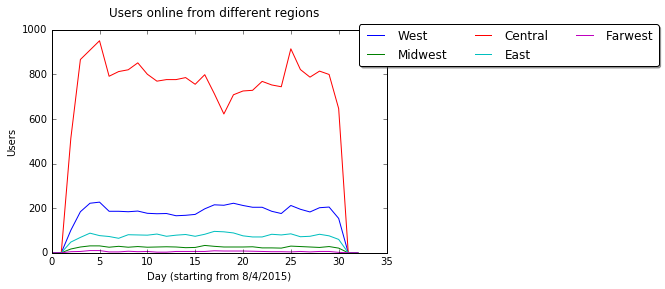

In [13]:
import matplotlib.pyplot as plt
%pylab inline
#plt.plot(freq)
fig = plt.figure()
ax=plt.subplot(111)
fig.suptitle('Users online from different regions', fontsize=12)
plt.xlabel('Day (starting from 8/4/2015)')
plt.ylabel('Users')
plt.plot(west_users, label='West')
plt.plot(midwest_users,label='Midwest')
plt.plot(central_users,label='Central')
plt.plot(east_users,label='East')
plt.plot(farwest_users,label='Farwest')
ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1.05),
          ncol=3, fancybox=True, shadow=True)


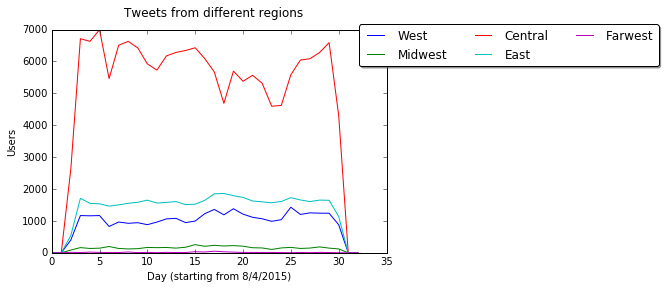

In [14]:
fig = plt.figure()
ax=plt.subplot(111)
fig.suptitle('Tweets from different regions', fontsize=12)
plt.xlabel('Day (starting from 8/4/2015)')
plt.ylabel('Users')

plt.plot(west_tweets, label='West')
plt.plot(midwest_tweets, label = 'Midwest')
plt.plot(central_tweets, label = 'Central')
plt.plot(east_tweets, label = 'East')
plt.plot(farwest_tweets, label = 'Farwest')

ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1.05),
          ncol=3, fancybox=True, shadow=True)

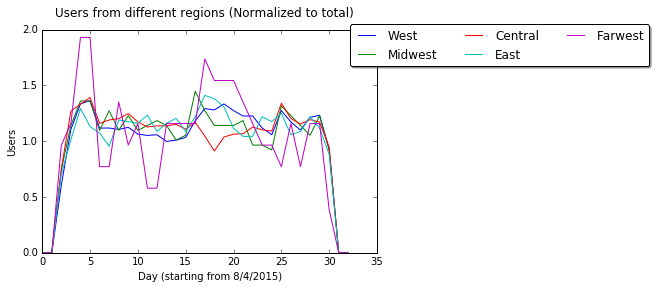

In [15]:
fig = plt.figure()
ax=plt.subplot(111)
fig.suptitle('Users from different regions (Normalized to total)', fontsize=12)
plt.xlabel('Day (starting from 8/4/2015)')
plt.ylabel('Users')

plt.plot(west_users/mean(west_users), label='West')
plt.plot(midwest_users/mean(midwest_users) ,label='Midwest')
plt.plot(central_users/mean(central_users), label='Central')
plt.plot(east_users/mean(east_users), label='East')
plt.plot(farwest_users/mean(farwest_users), label='Farwest')


ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1.05),
          ncol=3, fancybox=True, shadow=True)

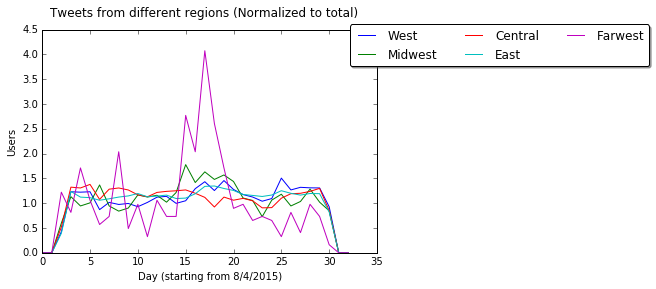

In [16]:
fig = plt.figure()
ax=plt.subplot(111)
fig.suptitle('Tweets from different regions (Normalized to total)', fontsize=12)
plt.xlabel('Day (starting from 8/4/2015)')
plt.ylabel('Users')

plt.plot(west_tweets/mean(west_tweets), label='West')
plt.plot(midwest_tweets/mean(midwest_tweets), label='Midwest')
plt.plot(central_tweets/mean(central_tweets), label='Central')
plt.plot(east_tweets/mean(east_tweets), label='East')
plt.plot(farwest_tweets/mean(farwest_tweets), label='Farwest')


ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1.05),
          ncol=3, fancybox=True, shadow=True)